# Credit Risk Asessment

## Libraries 

In [12]:
# All libraries for XGBoost
import pandas as pd
import numpy as np
import joblib

# XGBoost library
import xgboost as xgb

# Pipeline 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

# Split test and train set
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Libraries for graphics
import matplotlib.pyplot as plt
import seaborn as sns

## Import and data cleaning

In [13]:
path = 'credit_risk_dataset.csv'
df = pd.read_csv(path, delimiter=',')
nrows, ncols = df.shape

print(f'The number of rows are {nrows} and the number of columns {ncols}')


The number of rows are 32581 and the number of columns 12


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


Let's eliminate the missing values  

In [15]:
data = df.dropna(axis = 0) # This means it's going to drop rows (axis 0) containing missing values.
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


Before we start analyzing the dataset, let's focus on identifying outliers.

Here, we'll implement the Local Outlier Factor (LOF), an unsupervised anomaly detection technique used to identify outliers and anomalies in a dataset. It measures the local deviation of the density of a given sample with respect to its neighbors. It's local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is determined by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have substantially lower density than their neighbors. These are considered outliers.

[https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html]()

In [16]:
numerical_features = data._get_numeric_data()
cols_numerical = numerical_features.columns
cols_numerical



Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length'],
      dtype='object')

In [17]:
outlier_pipeline = Pipeline([
    ('prepocessing', ColumnTransformer([
        ('scaler', StandardScaler(), numerical_features.columns)
    ], remainder='passthrough')),
    ('outlier_detection', LocalOutlierFactor(n_neighbors=25))
])

# Fit the pipeline to your data and predict outlier scores
outlier_scores = outlier_pipeline.fit_predict(numerical_features)

outliers = data[outlier_scores == -1]
# Extract the detected outliers from your dataset based on the outlier scores
data = data[outlier_scores == 1]

In [18]:
# print("Detected outliers:")
# outliers
print("Let's see the dataset without the outliers")
data.head()

Let's see the dataset without the outliers


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


In [19]:
# It creates binary columns for each category in the original categorical column, and each column represents 
#the presence (1) or absence (0) of that category for a given row.
n_data = pd.get_dummies(data=data,columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])
n_data

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,False,False,...,False,False,True,False,False,False,False,False,True,False
2,25,9600,1.0,5500,12.87,1,0.57,3,True,False,...,False,False,False,True,False,False,False,False,True,False
3,23,65500,4.0,35000,15.23,1,0.53,2,False,False,...,False,False,False,True,False,False,False,False,True,False
4,24,54400,8.0,35000,14.27,1,0.55,4,False,False,...,False,False,False,True,False,False,False,False,False,True
5,21,9900,2.0,2500,7.14,1,0.25,2,False,False,...,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,30,True,False,...,False,False,False,True,False,False,False,False,True,False
32577,54,120000,4.0,17625,7.49,0,0.15,19,True,False,...,False,True,False,False,False,False,False,False,True,False
32578,65,76000,3.0,35000,10.99,1,0.46,28,False,False,...,False,False,True,False,False,False,False,False,True,False
32579,56,150000,5.0,15000,11.48,0,0.10,26,True,False,...,False,False,True,False,False,False,False,False,True,False


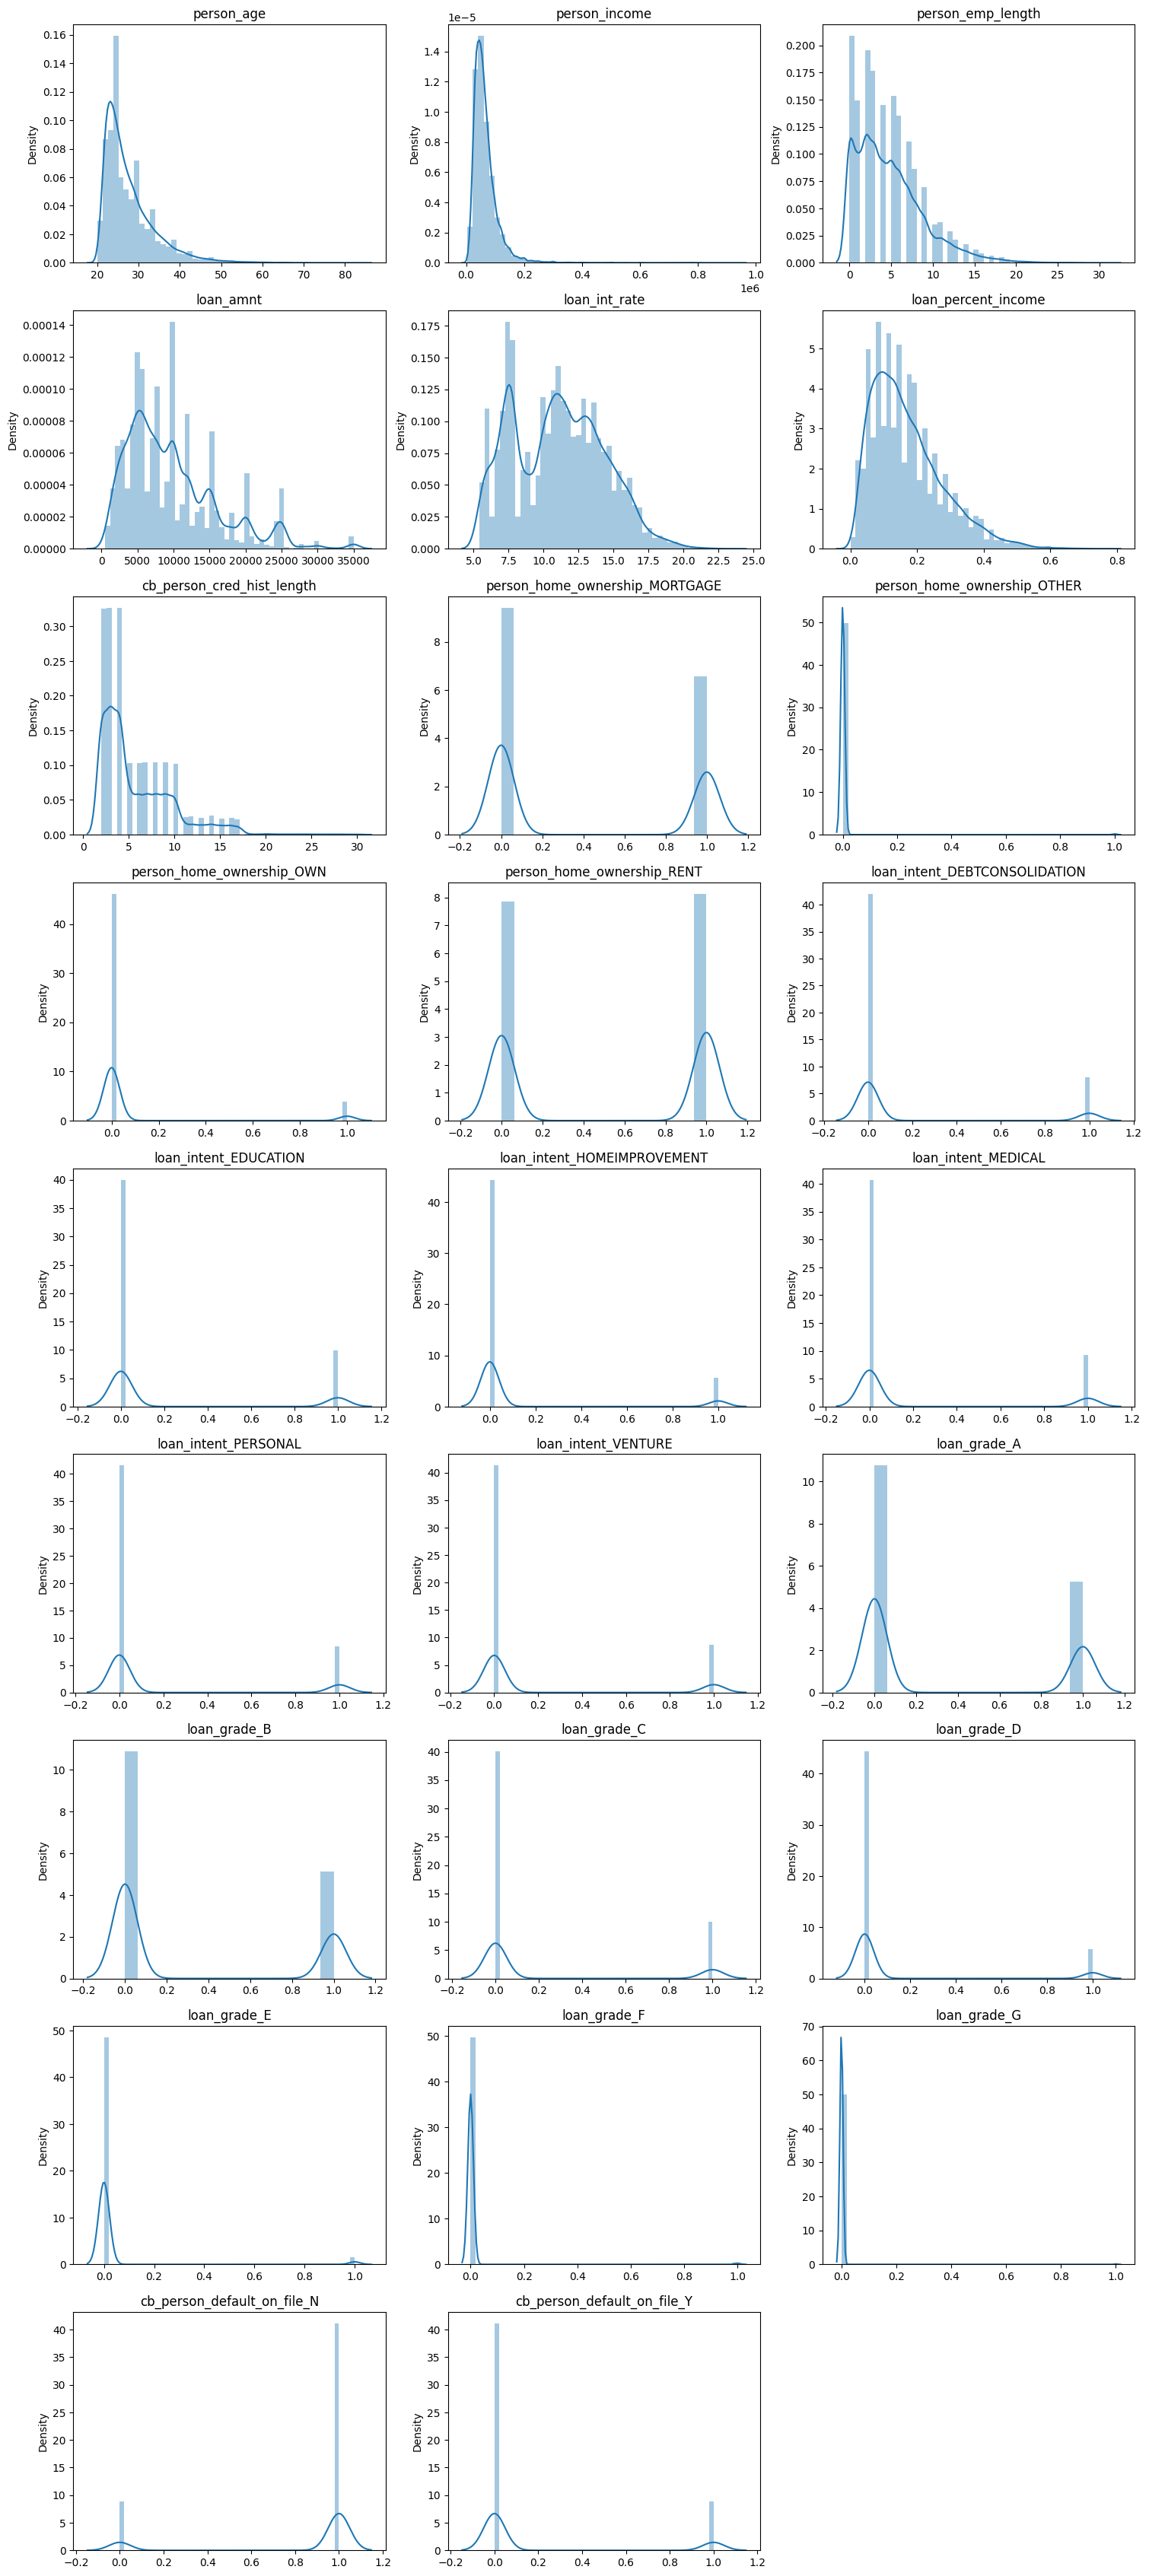

In [20]:
y=n_data['loan_status']
x=n_data.drop('loan_status',axis=1)

import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(18, 48))
for i in enumerate(x):
    plt.subplot(10, 3, i[0]+1)
    sns.distplot(df , x = n_data[i[1]])
    plt.title(i[1])
plt.savefig("data-distribution.png", dpi=300)

## XGBoost

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
print(f"The train set's are  {x_train.shape} and {y_train.shape}")
print(f"The train set's are  {x_test.shape} and {y_test.shape}")

The train set's are  (24276, 26) and (24276,)
The train set's are  (4285, 26) and (4285,)


In [22]:

# Define your XGBoost model
xgboost_model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree')

# Define the parameter grid for grid search
param_grid = {
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [1000, 2000, 3000],
}


# Define the preprocessing steps
preprocessing = ColumnTransformer([
    ('scaler', StandardScaler(),x.columns)], remainder='passthrough')

# Create the pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', xgboost_model)
])

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_log_loss')

# Fit the grid search to your data
grid_search.fit(x_train, y_train)

# Extract the best XGBoost model from the grid search
best_xgboost_model = grid_search.best_estimator_.named_steps['classifier']

# Pass the eval_set parameter to the specific step of the pipeline
best_xgboost_model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], eval_metric='logloss')





[0]	validation_0-logloss:0.51929	validation_1-logloss:0.51485
[1]	validation_0-logloss:0.51387	validation_1-logloss:0.50954
[2]	validation_0-logloss:0.50863	validation_1-logloss:0.50440
[3]	validation_0-logloss:0.50355	validation_1-logloss:0.49941
[4]	validation_0-logloss:0.49863	validation_1-logloss:0.49457
[5]	validation_0-logloss:0.49386	validation_1-logloss:0.48988
[6]	validation_0-logloss:0.48922	validation_1-logloss:0.48532
[7]	validation_0-logloss:0.48471	validation_1-logloss:0.48089
[8]	validation_0-logloss:0.48033	validation_1-logloss:0.47658
[9]	validation_0-logloss:0.47606	validation_1-logloss:0.47239
[10]	validation_0-logloss:0.47191	validation_1-logloss:0.46831
[11]	validation_0-logloss:0.46787	validation_1-logloss:0.46433
[12]	validation_0-logloss:0.46394	validation_1-logloss:0.46046
[13]	validation_0-logloss:0.46009	validation_1-logloss:0.45668
[14]	validation_0-logloss:0.45635	validation_1-logloss:0.45301
[15]	validation_0-logloss:0.45270	validation_1-logloss:0.44942
[1

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

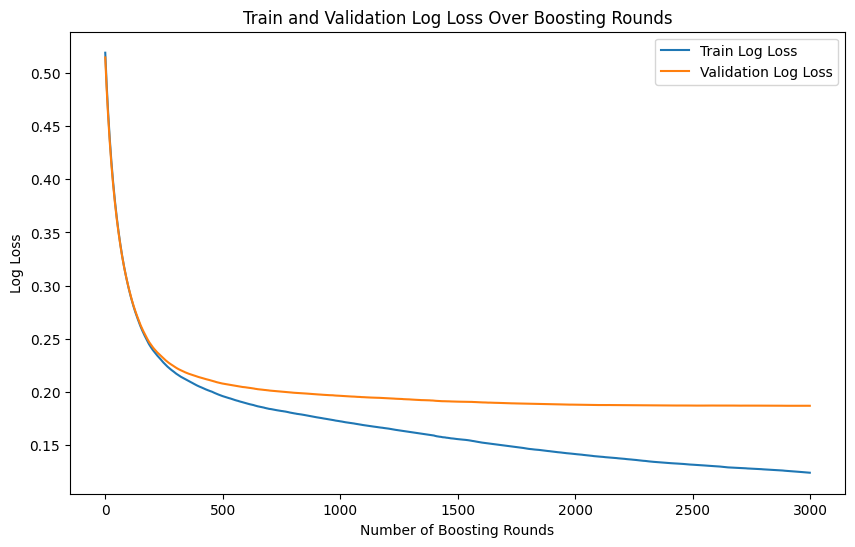

In [23]:
# Extract evaluation results from the best estimator
results = best_xgboost_model.evals_result()

# Extract the validation loss and train loss
train_logloss = results['validation_0']['logloss']
test_logloss = results['validation_1']['logloss']

# Plot the validation loss and train loss
plt.figure(figsize=(10, 6))
plt.plot(train_logloss, label='Train Log Loss')
plt.plot(test_logloss, label='Validation Log Loss')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Train and Validation Log Loss Over Boosting Rounds')
plt.legend()
plt.savefig("Train and Validation Log Loss.png", dpi=300)
plt.show()

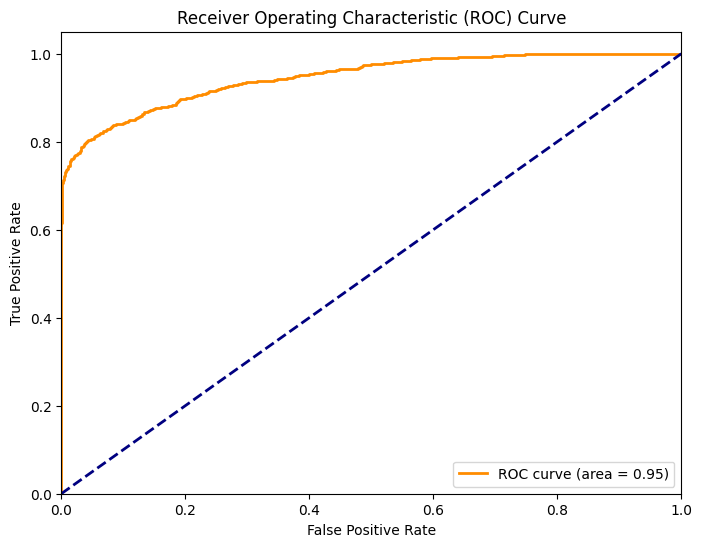

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Model Evaluation
y_pred = best_xgboost_model.predict(x_test)
probs = best_xgboost_model.predict_proba(x_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig("Roc curve.png", dpi=300)
plt.show()


### Feature Importance with XGBoost

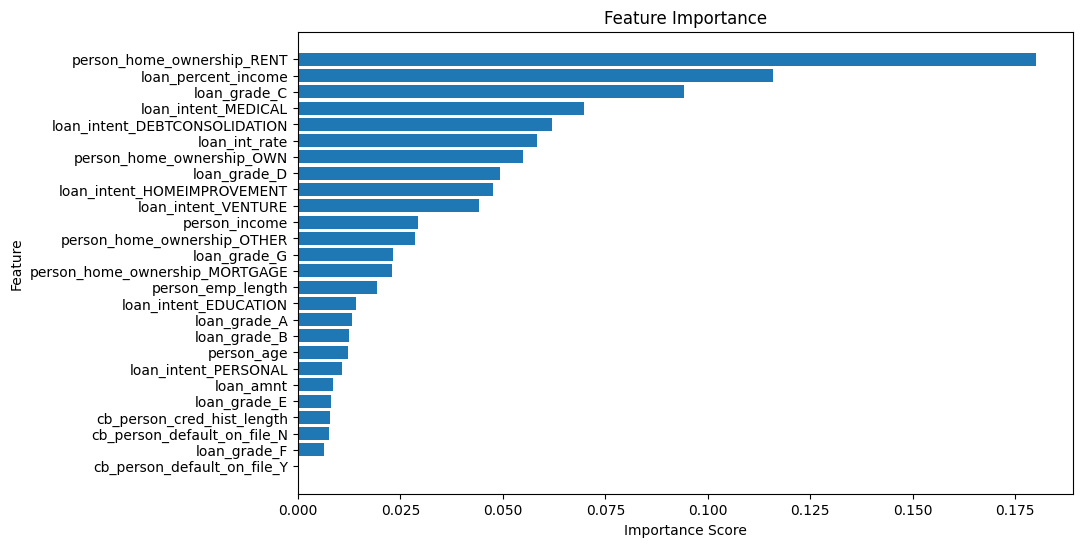

In [25]:
# Assuming you have trained an XGBoost model called "best_estimator" already

# Get feature importances from the XGBoost model
feature_importances = best_xgboost_model.feature_importances_
feature_names = x.columns  # Replace with your feature names

# Create a DataFrame with feature importances
fi = pd.DataFrame(data=feature_importances, index=feature_names, columns=['importance'])

# Sort the DataFrame by importance in descending order
fi = fi.sort_values(by='importance', ascending=True)

# Create a bar chart of feature importance
plt.figure(figsize=(10, 6))
plt.barh(fi.index, fi['importance'])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.savefig("Feature Importance.png", dpi=300)
plt.show()

In [26]:
print('XG boost tree','\n', classification_report(y_test, best_xgboost_model.predict(x_test)))

XG boost tree 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      3373
           1       0.95      0.74      0.83       912

    accuracy                           0.94      4285
   macro avg       0.94      0.87      0.90      4285
weighted avg       0.94      0.94      0.93      4285



## Let's save the parameters of the model
We use the joblib library to save a pickle file that contains the parameters of the trained model. With these parameters we will be able to make predicctions if someone can get a credit or not.

In [27]:
joblib.dump(xgboost_model, 'xgboost_model.pkl')


['xgboost_model.pkl']